# Camera calibration - DLT Algorithm implementation
Quero realizar a implementação do algoritmo "Direct Linear Transform" para reconstruir a matriz de câmera $C$
\begin{equation*}
C = \begin{bmatrix}
c_{11} & c_{12} & c_{13} & c_{14}\\ 
c_{21} & c_{22} & c_{23} & c_{24}\\ 
c_{31} & c_{32} & c_{33} & c_{34} \end{bmatrix}
\end{equation*}

Nos é fornecido: 
- Os pontos $P_i = (X_w^i,Y_w^i,Z_w^i)$, referente ao sistema de coordenadas do mundo, e as suas respectivas projeções no plano da imagem (coordenadas em pixel $(u_i,v_i)$).

A partir deste conjunto de pontos e suas correspondências criar a matriz de correspondências $Q$

\begin{equation*}
Q = 
\begin{bmatrix}
X_w^1 &Y_w^1  &Z_w^1  &1  &0  &0  &0  &0  &-u_1 X_w^1 &-u_1 Y_w^1 &-u_1Z_w^1  &-u_1 \\ 
0 &0  &0  &0  &X_w^1 &Y_w^1  &Z_w^1  &1 &-v_1 X_w^1 &-v_1 Y_w^1 &-v_1Z_w^1  &-v_1\\ 
 &  &  &  &  &  &  &\vdots   &  &  &  & \\ 
X_w^n &Y_w^n  &Z_w^n  &1  &0  &0  &0  &0  &-u_n X_w^n &-u_n Y_w^n &-u_n Z_w^n  &-u_n \\ 
0 &0  &0  &0  &X_w^n &Y_w^n  &Z_w^n  &1 &-v_n X_w^n &-v_n Y_w^n &-v_nZ_w^n  &-v_n 
\end{bmatrix}

\end{equation*}

A matriz de câmera C é expressa a partir de um vetor coluna $c$. Este vetor é encontrado calculando o SVD da matriz Q

\begin{equation*}
    U\Sigma V^T = \text{SVD}(Q)
\end{equation*}

---

## Validação

Para validar a implementação, é preciso gerar esses pontos para serem utilizados no cálculo da matriz de câmera. 
- É possível utilizar uma imagem de alguma outra implementação com os dados gerados por outra pessoa e comparar com o resultado obtido.
    - Porém, nada garante que os pontos que ela obteve estão corretos ou que a matriz de câmera calculada também estará correta. 
  
  
A melhor forma ainda é utilizar um ambiente simulado, onde eu posso criar uma câmera com as características ($K,R,t$) que eu determinar. 
- A partir dessa câmera criada, eu pego um conjunto de pontos do mundo e obtenho os pontos na imagem geradas por essa câmera, a partir da projeção dos `world_points`. 
- Com os pontos do mundo e da imagem, usá-los como entrada do algoritmo de calibração e encontrar a matriz de câmera $C$. 
- Usando a matriz de câmera $C$ encontrada, projetar novamente os `world_points` e encontrar os `image_points_projected`
- Comparar os `image_points` com `image_points_projected`
    - Plotar os dois em coordenadas de pixel para ver o erro de reprojeção

---
  

## Implementação em Python

In [4]:
# Importing library 
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Tentativa própria de simulação da câmera

TO-DO:
- Separar as funções de plot em um arquivo especifico
- Procurar pela implementação de Lorenzo

In [96]:
import cv2

# Criação de uma matriz de projeção da câmera simulada
focal_length = 1000  # Comprimento focal
image_width = 640    # Largura da imagem
image_height = 480   # Altura da imagem
principal_point = (image_width / 2, image_height / 2)  # Ponto principal

k_matrix = np.array([[focal_length, 0, principal_point[0]],
                          [0, focal_length, principal_point[1]],
                          [0, 0, 1]], dtype=np.float64)

# Geração de pontos 3D no mundo real e projeção na imagem
num_points = 20
world_points = np.random.rand(num_points, 3)  # Pontos 3D no mundo real
world_points = world_points * 5
print(world_points)
# Parâmetros intrínsecos e extrínsecos da câmera
rotation_matrix = np.identity(3)  # Matriz de rotação
translation_vector = np.zeros((3,1)) # Vetor de translação
print(translation_vector)
# Projete os pontos 3D na imagem
image_points = cv2.projectPoints(world_points, rotation_matrix, translation_vector, k_matrix, None)[0]



def plot_image_points(image_points):
    """
    Plota os pontos 2D na imagem.

    :param image_points: Array de pontos 2D projetados na imagem.
    """

    if image_points.shape[1] != 2:
        raise ValueError("A matriz de image_points deve ter duas colunas (X e Y).")
    plt.figure(figsize=(8, 6))
    plt.scatter(image_points[:, 0], image_points[:, 1], c='b', marker='o', label='Pontos Projetados')
    plt.xlabel('Coordenada X na Imagem')
    plt.ylabel('Coordenada Y na Imagem')
    plt.title('Pontos 2D Projetados na Imagem')
    plt.grid()
    plt.legend()
    plt.show()

print(image_points)
#plot_image_points(image_points)

[[1.70533176 0.56736761 4.62346809]
 [4.38669677 1.28970814 3.29992023]
 [4.086111   2.77600406 2.64825289]
 [1.20926145 0.46551384 4.48607879]
 [4.50209029 3.16550729 1.69514896]
 [1.74604787 3.62977839 4.4855513 ]
 [4.43543212 3.89937773 3.21015823]
 [0.42069982 0.80814357 4.49277094]
 [3.0321453  0.04598526 0.50735771]
 [3.31750885 0.02530792 0.80404026]
 [2.74366895 3.45947599 3.2598063 ]
 [1.12134655 3.56089611 1.18624544]
 [1.62699849 3.73245703 3.2481645 ]
 [4.24611705 3.28806446 2.84154302]
 [0.46837384 1.83857902 1.32601184]
 [1.21994822 4.86505277 1.96548862]
 [4.46023278 3.15569313 3.97405652]
 [2.51318547 2.88451942 2.46258847]
 [0.97621494 3.61226058 1.40386181]
 [0.12157983 3.22736148 0.8855534 ]]
[[0.]
 [0.]
 [0.]]
[[[ 688.84254883  362.71472301]]

 [[1649.33418414  630.83009546]]

 [[1862.94592246 1288.23979108]]

 [[ 589.558675    343.76853837]]

 [[2975.86706814 2107.39181626]]

 [[ 709.26048469 1049.21566866]]

 [[1701.68644736 1454.69954095]]

 [[ 413.63927749  419.

[[ 688.84254883  362.71472301]
 [1649.33418414  630.83009546]
 [1862.94592246 1288.23979108]
 [ 589.558675    343.76853837]
 [2975.86706814 2107.39181626]
 [ 709.26048469 1049.21566866]
 [1701.68644736 1454.69954095]
 [ 413.63927749  419.87642388]
 [6296.34610188  330.63675743]
 [4446.04818763  271.47593545]
 [1161.66625144 1301.25201093]
 [1265.29050386 3241.82069765]
 [ 820.89781265 1389.09729204]
 [1814.29976163 1397.14048396]
 [ 673.21995292 1626.54796439]
 [ 940.6844458  2715.23832802]
 [1442.33752993 1034.07354071]
 [1340.54626547 1411.33636388]
 [1015.37822776 2813.08842288]
 [ 457.29249141 3884.45722905]]


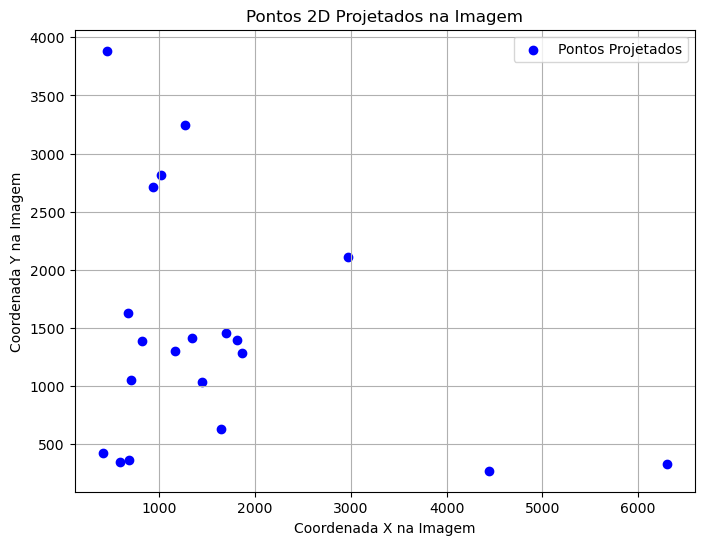

In [97]:
image_points = image_points.reshape(-1,2)
print(image_points)
#print(image_points[:,0])

plot_image_points(image_points)

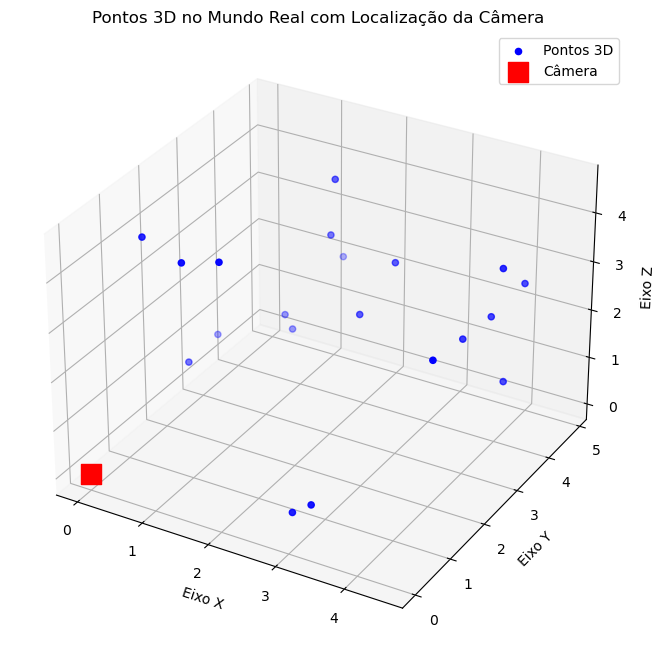

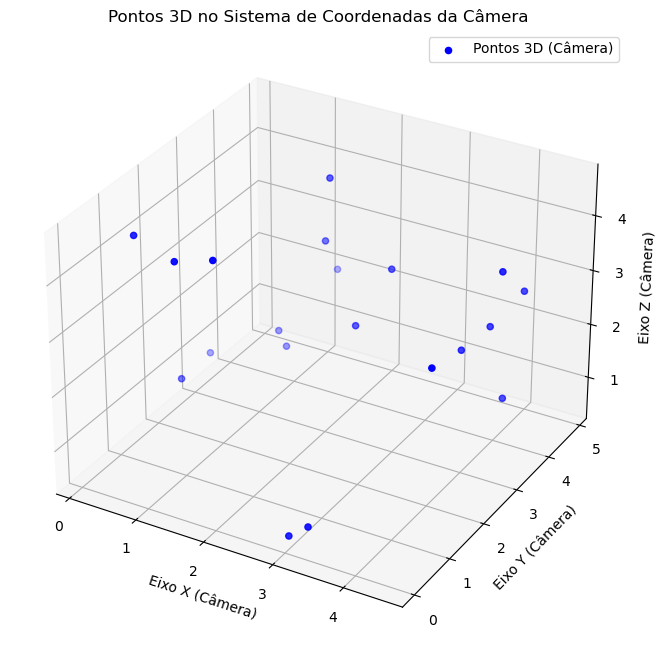

In [98]:
from mpl_toolkits.mplot3d import Axes3D

def plot_world_points_with_camera(world_points, camera_position):
    """
    Plota os pontos 3D no mundo real juntamente com a localização da câmera.

    :param world_points: Array de pontos 3D no mundo real.
    :param camera_position: Vetor 3D que representa a posição da câmera no mundo real.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plota os pontos 3D no mundo real
    ax.scatter(world_points[:, 0], world_points[:, 1], world_points[:, 2], c='b', marker='o', label='Pontos 3D')
    
    # Plota a localização da câmera
    ax.scatter(camera_position[0], camera_position[1], camera_position[2], c='r', marker='s', s=200, label='Câmera')
    
    ax.set_xlabel('Eixo X')
    ax.set_ylabel('Eixo Y')
    ax.set_zlabel('Eixo Z')
    ax.set_title('Pontos 3D no Mundo Real com Localização da Câmera')
    ax.legend()
    plt.show()

plot_world_points_with_camera(world_points,[0,0,0])


def plot_world_points_with_camera_reference(world_points, rotation_matrix, translation_vector):
    """
    Plota os pontos 3D no sistema de coordenadas da câmera com base no vetor de rotação e translação.

    :param world_points: Array de pontos 3D no sistema de coordenadas do mundo.
    :param rotation_matrix: Matriz de rotação da câmera.
    :param translation_vector: Vetor de translação da câmera.
    """
    num_points = world_points.shape[0]

    # Repete o vetor de translação para ter o mesmo número de linhas que world_points
    translation_matrix = np.repeat(translation_vector.reshape(1, -1), num_points, axis=0)

    # Transforma os pontos do sistema de coordenadas do mundo para o sistema da câmera
    camera_points = np.dot(world_points, rotation_matrix.T) + translation_matrix

    # Cria uma figura 3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plota os pontos 3D no sistema de coordenadas da câmera
    ax.scatter(camera_points[:, 0], camera_points[:, 1], camera_points[:, 2], c='b', marker='o', label='Pontos 3D (Câmera)')

    ax.set_xlabel('Eixo X (Câmera)')
    ax.set_ylabel('Eixo Y (Câmera)')
    ax.set_zlabel('Eixo Z (Câmera)')
    ax.set_title('Pontos 3D no Sistema de Coordenadas da Câmera')
    ax.legend()
    plt.show()

plot_world_points_with_camera_reference(world_points,rotation_matrix,translation_vector)

In [156]:
import plotly.graph_objs as go
import plotly.offline as pyo

def plot_world_points_with_camera_plotly(world_points, camera_position):
    """
    Plota os pontos 3D no mundo real juntamente com a localização da câmera usando Plotly.

    :param world_points: Array de pontos 3D no mundo real.
    :param camera_position: Vetor 3D que representa a posição da câmera no mundo real.
    """
    # Cria uma figura 3D
    fig = go.Figure()

    # Plota os pontos 3D no mundo real
    fig.add_trace(go.Scatter3d(
        x=world_points[:, 0],array_like(3,n)
        y=world_points[:, 1],
        z=world_points[:, 2],
        mode='markers',
        marker=dict(size=4, color='blue'),
        name='Pontos 3D'
    ))

    # Plota a localização da câmera
    fig.add_trace(go.Scatter3d(
        x=[camera_position[0]],
        y=[camera_position[1]],
        z=[camera_position[2]],
        mode='markers',
        marker=dict(size=8, color='red', symbol='square'),
        name='Câmera'
    ))

    # Configuração do layout
    fig.update_layout(
        scene=dict(
            xaxis_title='Eixo X',
            yaxis_title='Eixo Y',
            zaxis_title='Eixo Z',
        ),
        scene_aspectmode='cube',
        showlegend=True,
    )

    # Exibe o gráfico interativo
    pyo.plot(fig, filename='world_points_with_camera.html')

plot_world_points_with_camera_plotly(world_points,[0,0,0])

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3401696795.py, line 16)

# Simulação da câmera via Machine Vision Toolbox

Para definir uma pose (parâmetros extrinsecos): 

- pose (SE3, optional) – camera pose, defaults to None


           Name: mycamera [CentralCamera]
     pixel size: 1e-05 x 1e-05
     image size: 1280 x 1024
           pose: t = 0, 0, 0; rpy/yxz = 0°, 0°, 0°
   principal pt: [640. 512.]
   focal length: [0.015 0.015]



<Axes3DSubplot:xlabel='X', ylabel='Y'>

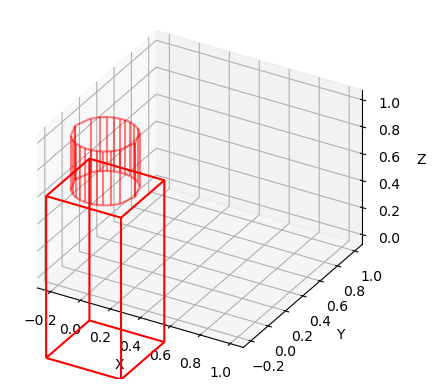

In [114]:
from machinevisiontoolbox import CentralCamera
from spatialmath import SE3

cam = CentralCamera(f=0.015, rho=10e-6, imagesize=[1280, 1024], pp=[640, 512],pose = SE3(0, 0, 0), name="mycamera")
print(cam)

cam.pose
cam.plot()

In [160]:

image_p = []
print(len(world_points))

p_image = cam.project_point(world_points, behind= True)

for i in range(len(world_points)): 
    image_point = cam.project_point(world_points[i], behind= True)
    image_p.append(image_point)

#p_image
image_p

4


[array([[2397.10292726],
        [ 605.47638681]]),
 array([[3288.34973858],
        [4613.8477277 ]]),
 array([[2606.99508079],
        [1823.1259603 ]]),
 array([[14258.8786756 ],
        [ 9113.71215311]])]

# Calibração via DLT

In [36]:
#Define world and image points
world_points = []

image_points = []

#Faça teste de compatibilidade
if len(world_points) != len(image_points): 
    print("Must be the same number of World points and Image points")

if len(world_points) < 6 | len(image_points) < 6 :
    print("Must have a minimum of 6 points to compute C")

#Normalize os pontos

### Crie a matriz de coeficientes Q

\begin{equation*}
Q = 
\begin{bmatrix}
X_w^1 &Y_w^1  &Z_w^1  &1  &0  &0  &0  &0  &-u_1 X_w^1 &-u_1 Y_w^1 &-u_1Z_w^1  &-u_1 \\ 
0 &0  &0  &0  &X_w^1 &Y_w^1  &Z_w^1  &1 &-v_1 X_w^1 &-v_1 Y_w^1 &-v_1Z_w^1  &-v_1\\ 
 &  &  &  &  &  &  &\vdots   &  &  &  & \\ 
X_w^n &Y_w^n  &Z_w^n  &1  &0  &0  &0  &0  &-u_n X_w^n &-u_n Y_w^n &-u_n Z_w^n  &-u_n \\ 
0 &0  &0  &0  &X_w^n &Y_w^n  &Z_w^n  &1 &-v_n X_w^n &-v_n Y_w^n &-v_nZ_w^n  &-v_n 
\end{bmatrix}

\end{equation*}

In [37]:
Q = []
for i in range(len(world_points)):
    X, Y, Z = world_points[i]
    u,v  = image_points[i]
    Q.append([X, Y, Z, 1, 0, 0, 0, 0, -u*X, -u*Y, -u*Z, -u])
    Q.append([0, 0, 0, 0, X, Y, Z, 1, -v*X, -v*Y, -v*Z, -v])

Q = np.array(Q)
print(Q)

[[-1.00000000e+00 -2.00000000e+00 -3.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.19699945e+02  4.39399890e+02  6.59099835e+02 -2.19699945e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.00000000e+00 -2.00000000e+00 -3.00000000e+00  1.00000000e+00
   3.93999038e+01  7.87998077e+01  1.18199712e+02 -3.93999038e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -3.19999945e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -2.39999904e+02]
 [ 1.00000000e+00  2.00000000e+00  3.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -4.20299945e+02 -8.40599890e+02 -1.26089983e+03 -4.20299945e+02]
 [ 0.

### Encontre a Matriz de câmera C via SVD

In [45]:
# Resolva o sistema de equações usando SVD
_, _, V = svd(Q)
c = V[-1, :12]
print(c)

# Reconstrua a matriz de projeção da câmera
C_matrix = c.reshape(3, 4)
print(C_matrix)

[ 3.74088251e-03 -7.63606578e-03  3.81795574e-03 -2.46881180e-04
 -4.08220544e-01  8.16363937e-01 -4.08220698e-01 -1.85160843e-04
 -5.39748212e-03  1.07949642e-02 -5.39748212e-03 -7.71503821e-07]
[[ 3.74088251e-03 -7.63606578e-03  3.81795574e-03 -2.46881180e-04]
 [-4.08220544e-01  8.16363937e-01 -4.08220698e-01 -1.85160843e-04]
 [-5.39748212e-03  1.07949642e-02 -5.39748212e-03 -7.71503821e-07]]


[-2.46881180e-04 -1.85160843e-04 -7.71503821e-07]


## Implementação de Lorenzo


In [20]:



nPoints = 7
P = np.zeros((nPoints,4)) # 6x3 Matrix with zeros
u = np.zeros(nPoints)   # 6x1 Column Matrix
v = np.zeros(nPoints)   # 6x1 Column Matrix

Q = np.ones(12)

for n in range(nPoints):
    firstLine = np.hstack((P[n], np.zeros(4), -u[n]*P[n])) 
    secondLine = np.hstack((np.zeros(4), P[n], -v[n]*P[n]))
    nLine = np.vstack((firstLine, secondLine))
    Q = np.vstack((Q, nLine))

Q = np.delete(Q, 0, 0)

print(Q)



[[ 0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.]]
